# Introduction to VCFtools
VCFtools is used in variant calling from .vcf (variance call format) and .bcf (binary variant call format) files. This is a free and open source command line software and is typically run in a bash shell.

Pipelines vary by species and project depending on the quality of the reference genome and sequence data and the questions being asked.

Some typical uses include: QC analysis, SNP filtering, and various metrics used on genomic data like hardy-weinburg equilibrium calculations or linkage disequilibrium. The manual provides a complete list of commands available in VCFtools. http://vcftools.sourceforge.net/man_latest.html

The general command structure is:
--vcf <filename.vcf> --COMMAND --recode --out <new_filename>

Including the --recode --out <new_filename> ensures that the results from that command will be saved in a new .vcf file. With each command it is good practice to use a new filename to ensure that you can go back a step in the pipeline if you want to try something else or if you make a mistake. A handy trick is to rename the file including the filters that have been run on it. For example a file that has been filtered for quality may be named filename_qc.vcf. 

## Pipeline Description
This pipeline is designed to process raw .vcf files into a useful SNP set that can be used for futher downstream analysis and includes the following steps/filters:

1. Quality
2. Depth
3. Minor Allele Frequencies 1
4. Missing individuals and missing sites
5. Minor Allele Frequencies 2
6. Biallelic sites
7. Minor Allele Frequencies 3
8. Hardy Weinberg (excess of heterozygosity)
9. Linkage Disequilibrium 

## Step 1: Quality Filtering
Quality scores in .vcf and .bcf files give an indication of the likelihood that the base called was correct. This is reported as a phred score.
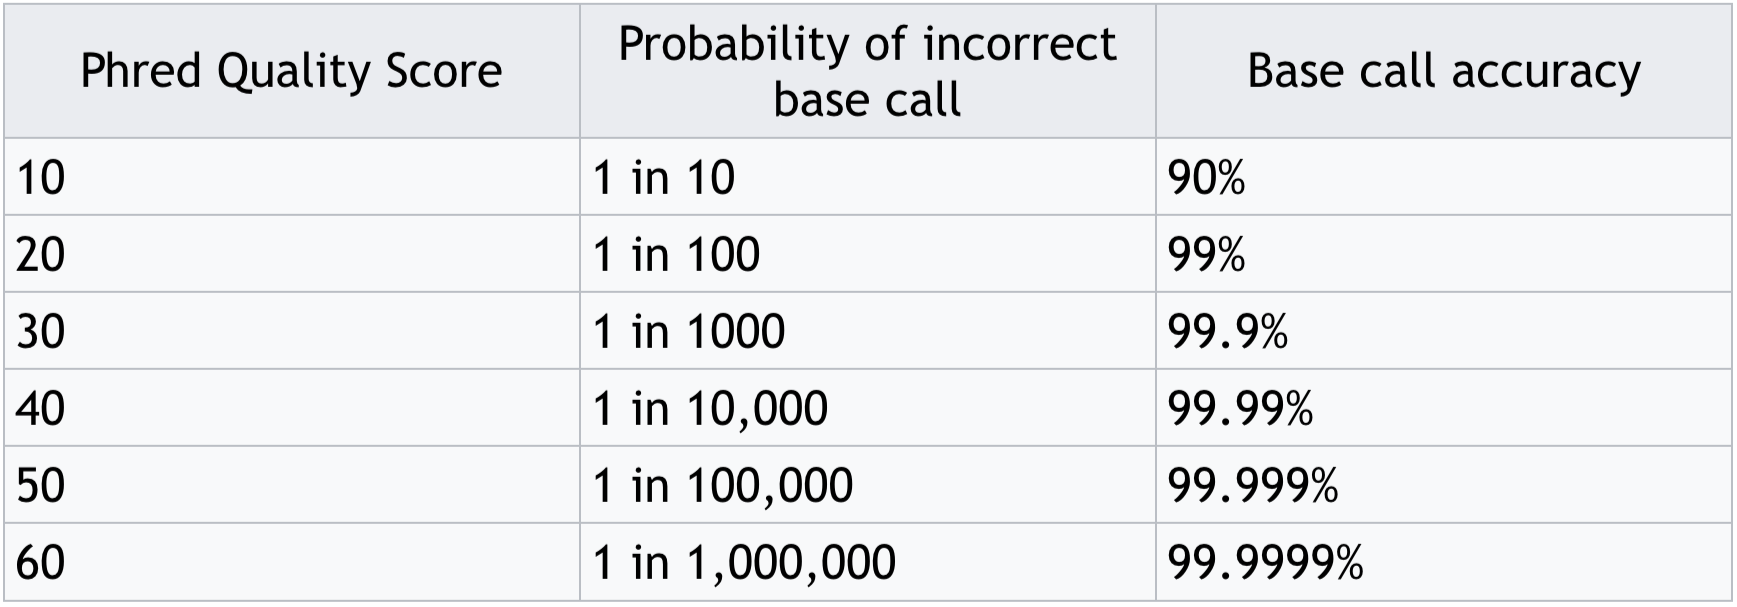

Here we will filter out all quality scores below 30 (99.9% probability of correct call). 
From the manual:
--site-quality Generates a file containing the per-site SNP quality, as found in the QUAL column of the VCF file. 
--minQ <float> Includes only sites with Quality value above this threshold.

In [1]:
# allows us to run R kernels
%load_ext rpy2.ipython

In [2]:
# shows us the available line and kernel magics
%lsmagic

Available line magics:
%R  %Rdevice  %Rget  %Rpull  %Rpush  %alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %conda  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%R  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%lat

In [71]:
%%bash
vcftools --vcf filename2.vcf --minQ 30 --recode --out filename_q


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf filename2.vcf
	--minQ 30
	--out filename_q
	--recode

After filtering, kept 240 out of 240 Individuals
Outputting VCF file...
After filtering, kept 27347 out of a possible 37210 Sites
Run Time = 20.00 seconds


## Step 2: Depth Statistics 
Depth statistics tell us how many reads occured per individual, per site, per genotype etc. VCFtools provides commands to filter by depth in a number of ways:
-- depth (per individual) 

--site-depth (per site summed)*

--site-mean-depth (per site averaged)*

--geno-depth (by genotype)

--minDP <float> (filter out minimum depth)

*Using these could result in the loss of individuals that have a few low quality sites, which would also throw out the high quality sites that individual had and cause data loss. SO we will use a filter per individual.

In [72]:
%%bash
vcftools --vcf filename_q.recode.vcf --minDP 5 --recode --out filename_q_dp


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf filename_q.recode.vcf
	--minDP 5
	--out filename_q_dp
	--recode

After filtering, kept 240 out of 240 Individuals
Outputting VCF file...
After filtering, kept 27347 out of a possible 27347 Sites
Run Time = 19.00 seconds


## Step 3: Minor Allele Frequencies
After filtering for quality and depth there may be some sites that no longer contain any data and others that are now monoallelic. We will use a broad filter here to remove sites that have a minor allele frequency of zero.

--maf <float> filters out site below the designated Minor Allele Frequency
    
--max-maf <float> Include only sites with a Minor Allele Frequency greater than or equal to the "--maf" value and less than or equal to the "--max-maf" value.

In [73]:
%%bash
vcftools --vcf filename_q_dp.recode.vcf --maf 0.000000001 --recode --out filename_q_dp_maf


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf filename_q_dp.recode.vcf
	--maf 1e-09
	--out filename_q_dp_maf
	--recode

After filtering, kept 240 out of 240 Individuals
Outputting VCF file...
After filtering, kept 20066 out of a possible 27347 Sites
Run Time = 15.00 seconds


## Step 4: Missing Individuals and Missing Sites
Things will get a little more complicated now. There will be some individuals that only have a few SNPs and some SNPs that are present in only a few individuals. This is problematic because it may skew results when comparing genetic variation among groups. 

For example: A SNP present in 4 individuals could have an allele frequency of 75% in one group and 25% in another. This appears to show high genetic divergence amoung these groups, however, it is based only on 4 total individuals.

To remove this type of bias we will use:

--missing-indv  Generates a file reporting the missingness on a per-individual basis. The file has the suffix ".imiss".

--missing-site  Generates a file reporting the missingness on a per-site basis. The file has the suffix ".lmiss".

--max-missing <float> Exclude sites on the basis of the proportion of missing data (defined to be between 0 and 1, where 0 allows sites that are completely missing and 1 indicates no missing data allowed).

Note: 1-missingness = % present

As you can imagine, once you remove an individual or a site the dataset changes. Sites that were present in many individuals may not be anymore and individuals that didn't have many missing sites may now have more. A judgement call has to be made to choose to filter out individuals or missing sites first and how many iterations of this step to repeat. 

It can be useful to generate a histogram showing the number of individuals or sites and the percent missingness and set a threshold of % missingness to accept based on this distribution. 

In [74]:
%%bash
# output missingness per indv
vcftools --vcf filename_q_dp_maf.recode.vcf --missing-indv


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf filename_q_dp_maf.recode.vcf
	--missing-indv

After filtering, kept 240 out of 240 Individuals
Outputting Individual Missingness
After filtering, kept 20066 out of a possible 20066 Sites
Run Time = 3.00 seconds


Now we will switch over to an R kernel and read in the missingness data as a table that we can then plot. This could also be done using a python package as the purpose is to view the distribution of data missingness.

In [75]:
%%R
# read in the missing individual data and view it
vcf_missindv <- read.table("out.imiss", sep="\t", header=TRUE)
head(vcf_missindv)

    INDV N_DATA N_GENOTYPES_FILTERED N_MISS   F_MISS
1 BaFT01  20066                    0  12620 0.628925
2 BaFT03  20066                    0  11392 0.567727
3 BaFT06  20066                    0  16547 0.824629
4 BaFT08  20066                    0  14747 0.734925
5 BaFT09  20066                    0  13615 0.678511
6 BaFT10  20066                    0  14080 0.701684


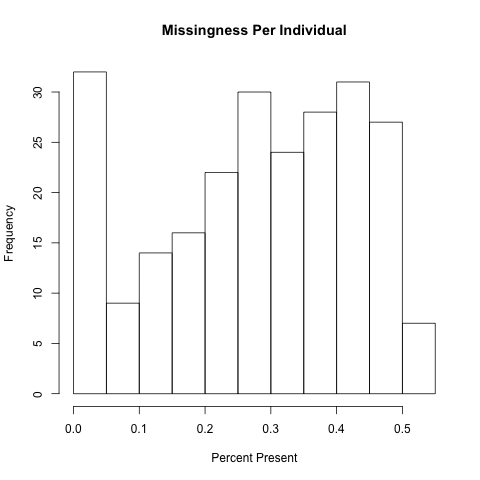

In [76]:
%%R
# Plot histogram of percent PRESENT (1-missingness) per individual
hist(1-vcf_missindv$F_MISS, xlab="Percent Present", main="Missingness Per Individual")

Determine a threshold cutoff based on distribution of present data.

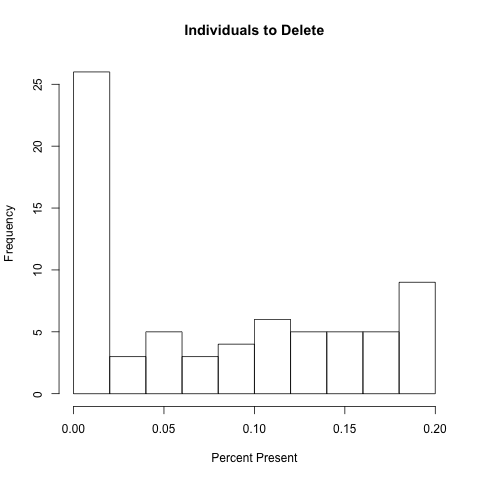

In [77]:
%%R
# Plot histogram of percent PRESENT (1-missingness) per individual in individuals potentially being removed
vcf_missindv_to_delete <- subset(vcf_missindv, 1-vcf_missindv$F_MISS < 0.2)
hist(1-vcf_missindv_to_delete$F_MISS, xlab="Percent Present", main="Individuals to Delete")

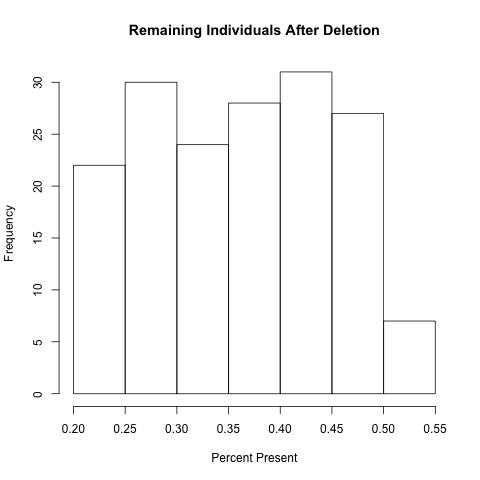

In [78]:
%%R
# look at the distribution of missingness if individuals above were deleted
vcf_missindv_filtered <- subset(vcf_missindv, 1-vcf_missindv$F_MISS > 0.2)
hist(1-vcf_missindv_filtered$F_MISS, xlab="Percent Present", main="Remaining Individuals After Deletion")

In [79]:
%%bash
#generate a list of individuals to remove
awk '$5 > 0.8' out.imiss | cut -f1 -f5 > missing.indv

In [80]:
%%bash
# remove all individuals in the list generated above
vcftools --vcf filename_q_dp_maf.recode.vcf --remove missing.indv --recode --out filename_q_dp_maf_missindv


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf filename_q_dp_maf.recode.vcf
	--remove missing.indv
	--out filename_q_dp_maf_missindv
	--recode

Excluding individuals in 'exclude' list
After filtering, kept 169 out of 240 Individuals
Outputting VCF file...
After filtering, kept 20066 out of a possible 20066 Sites
Run Time = 12.00 seconds


Now filter by missingness per site.

In [81]:
%%bash
# generate missingness per site now that individuals have been removed
vcftools --vcf filename_q_dp_maf_missindv.recode.vcf --missing-site


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf filename_q_dp_maf_missindv.recode.vcf
	--missing-site

After filtering, kept 169 out of 169 Individuals
Outputting Site Missingness
After filtering, kept 20066 out of a possible 20066 Sites
Run Time = 2.00 seconds


In [82]:
%%R
# read in the missing sites data and view it
vcf_misssites <- read.table("out.lmiss", sep="\t", header=TRUE)
head(vcf_misssites)

             CHR   POS N_DATA N_GENOTYPE_FILTERED N_MISS   F_MISS
1    NC_012312.1  4235    338                   0     88 0.260355
2    NC_012312.1  4922    338                   0    338 1.000000
3    NC_012312.1  5950    338                   0    338 1.000000
4    NC_012312.1 14266    338                   0      0 0.000000
5 NW_012224401.1 63691    338                   0    206 0.609467
6 NW_012224401.1 86594    338                   0    238 0.704142


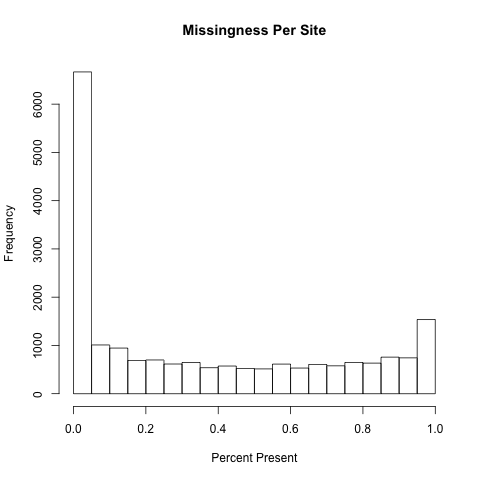

In [83]:
%%R
# plot missingness per site and determine a cutoff
hist(1-vcf_misssites$F_MISS, xlab="Percent Present", main="Missingness Per Site")

In [84]:
%%bash
# filter out by missingness based on the determined cutoff
vcftools --vcf filename_q_dp_maf_missindv.recode.vcf --max-missing 0.5 --recode --out filename_q_dp_maf_missindv_misssites


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf filename_q_dp_maf_missindv.recode.vcf
	--max-missing 0.5
	--out filename_q_dp_maf_missindv_misssites
	--recode

After filtering, kept 169 out of 169 Individuals
Outputting VCF file...
After filtering, kept 7159 out of a possible 20066 Sites
Run Time = 5.00 seconds


Look at missingness per individual again to determine if removing sites shifted the distribution of missingness per individual.

In [85]:
%%bash
# output missingness per indv for the second time
vcftools --vcf filename_q_dp_maf_missindv_misssites.recode.vcf --missing-indv


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf filename_q_dp_maf_missindv_misssites.recode.vcf
	--missing-indv

After filtering, kept 169 out of 169 Individuals
Outputting Individual Missingness
After filtering, kept 7159 out of a possible 7159 Sites
Run Time = 1.00 seconds


In [86]:
%%R
# read in the missing individual data and view it
vcf_missindv <- read.table("out.imiss", sep="\t", header=TRUE)
head(vcf_missindv)

    INDV N_DATA N_GENOTYPES_FILTERED N_MISS    F_MISS
1 BaFT01   7159                    0   1161 0.1621730
2 BaFT03   7159                    0    692 0.0966615
3 BaFT08   7159                    0   2561 0.3577320
4 BaFT09   7159                    0   1722 0.2405360
5 BaFT10   7159                    0   2058 0.2874700
6 BaFT13   7159                    0   1414 0.1975140


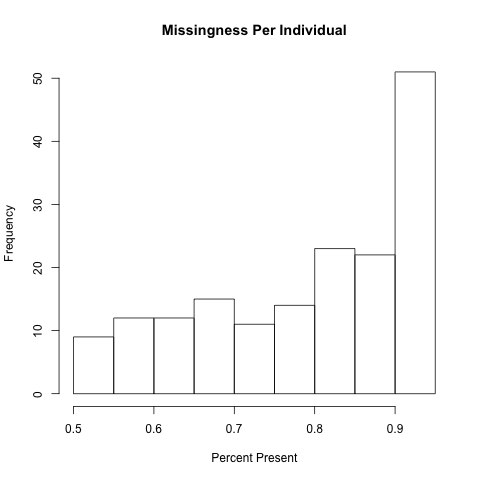

In [87]:
%%R
# Plot histogram of percent PRESENT (1-missingness) per individual for the second time
hist(1-vcf_missindv$F_MISS, xlab="Percent Present", main="Missingness Per Individual")

There are now only individuals with at least 50% of the data present so let's move on.

This can be iterated as many times as necessary to get the desired data distribution.

## Step 5: Repeat Minor Allele Frequency Filter
After completing steps 1-4 we want to do another MAF filter to ensure that there are no sites with no SNP data. This code is the same as step 3 above. 

In [90]:
%%bash
vcftools --vcf filename_q_dp_maf_missindv_misssites_missindv.recode.vcf --maf 0.000000001 --recode --out filename_q_dp_maf_missindv_misssite_missindv_maf


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf filename_q_dp_maf_missindv_misssites_missindv.recode.vcf
	--maf 1e-09
	--out filename_q_dp_maf_missindv_misssite_missindv_maf
	--recode

After filtering, kept 169 out of 169 Individuals
Outputting VCF file...
After filtering, kept 6380 out of a possible 7159 Sites
Run Time = 4.00 seconds


## Step 6: Biallelic Sites
For the species we typically work with we only want to investigate biallelic sites.
--min-alleles <integer> 
--max-alleles <integer>
Include only sites with a number of alleles greater than or equal to the "--min-alleles" value and less than or equal to the "--max-alleles" value. One of these options may be used without the other. 

In [91]:
%%bash
vcftools --vcf filename_q_dp_maf_missindv_misssite_missindv_maf.recode.vcf --min-alleles 2 --max-alleles 2 --recode --out filename_q_dp_maf_missindv_misssite_missindv_maf_bi


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf filename_q_dp_maf_missindv_misssite_missindv_maf.recode.vcf
	--max-alleles 2
	--min-alleles 2
	--out filename_q_dp_maf_missindv_misssite_missindv_maf_bi
	--recode

After filtering, kept 169 out of 169 Individuals
Outputting VCF file...
After filtering, kept 6013 out of a possible 6380 Sites
Run Time = 4.00 seconds


## Step 7: Yet annother Minor Allele Frequency Filter
Now that we are essentially done filtering we want to set the final allele frequency cut off to 5% because sites at lower frequencies are likely present in only a few individuals and may bias the results.

In [92]:
%%bash
vcftools --vcf filename_q_dp_maf_missindv_misssite_missindv_maf_bi.recode.vcf --maf 0.05 --recode --out filename_q_dp_maf_missindv_misssite_missindv_maf_bi_maf


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf filename_q_dp_maf_missindv_misssite_missindv_maf_bi.recode.vcf
	--maf 0.05
	--out filename_q_dp_maf_missindv_misssite_missindv_maf_bi_maf
	--recode

After filtering, kept 169 out of 169 Individuals
Outputting VCF file...
After filtering, kept 2547 out of a possible 6013 Sites
Run Time = 2.00 seconds


## Step 8: Hardy Weinberg Equilibrium
Our species has some paralogous regions that overlap in the reference genome and lead to all individuals being heterozygotes. KEEP excess of homozygotes because this could be wahlund effect (low heterozygosity due to subpopulation structure). 

--hwe <float>
    
Assesses sites for Hardy-Weinberg Equilibrium using an exact test, as defined by Wigginton, Cutler and Abecasis (2005). Sites with a p-value below the threshold defined by this option are taken to be out of HWE, and therefore excluded.

In [93]:
%%bash
vcftools --vcf filename_q_dp_maf_missindv_misssite_missindv_maf_bi_maf.recode.vcf --hwe 0.001 --recode --out filename_q_dp_maf_missindv_misssite_missindv_maf_bi_maf_hwe.vcf


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf filename_q_dp_maf_missindv_misssite_missindv_maf_bi_maf.recode.vcf
	--max-alleles 2
	--hwe 0.001
	--out filename_q_dp_maf_missindv_misssite_missindv_maf_bi_maf_hwe.vcf
	--recode

After filtering, kept 169 out of 169 Individuals
Outputting VCF file...
After filtering, kept 1627 out of a possible 2547 Sites
Run Time = 1.00 seconds


## Step 9: Linkage Disequilibrium
Finally, we want to assess linkage disequilibrium and remove SNPs that are in LD randomly keeping only one site. Sites that are in LD can inflate the results of future analysis.

There are multiple options to output correlation coefficients among SNPs that you can then filter by. There is also an option to set the number of bases between sites when looking for LD. The manual lists these under "OUTPUT LD STATISTICS".

*DO NOT* repeat any filters after this step, random selection of a site could lead to low MAF that would then get filtered out

*In order to use this filter data must be phased.

Our data isn't phased so we can't actually do this step.